In [ ]:
from warnings import filterwarnings
filterwarnings('ignore')

import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

# Dataset

[**Kaggle Dataset**](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) | [**Reference**](https://github.com/krishnaik06/Credit-Card-Fraudlent)

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

The dataset contains transactions made by credit cards in September 2013 by European cardholders.

This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) accounts for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependent cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.


In [ ]:
data = pd.read_csv('/content/creditcard.csv',sep=',')

FileNotFoundError: [Errno 2] No such file or directory: '/content/creditcard.csv'

In [ ]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1986 entries, 0 to 1985
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    1986 non-null   int64  
 1   V1      1986 non-null   float64
 2   V2      1986 non-null   float64
 3   V3      1986 non-null   float64
 4   V4      1986 non-null   float64
 5   V5      1986 non-null   float64
 6   V6      1986 non-null   float64
 7   V7      1986 non-null   float64
 8   V8      1986 non-null   float64
 9   V9      1986 non-null   float64
 10  V10     1986 non-null   float64
 11  V11     1986 non-null   float64
 12  V12     1986 non-null   float64
 13  V13     1986 non-null   float64
 14  V14     1985 non-null   float64
 15  V15     1985 non-null   float64
 16  V16     1985 non-null   float64
 17  V17     1985 non-null   float64
 18  V18     1985 non-null   float64
 19  V19     1985 non-null   float64
 20  V20     1985 non-null   float64
 21  V21     1985 non-null   float64
 22  

# Exploratory Data Analysis

Analyzing the dataset to gain insights into the distribution of fraudulent and non-fraudulent transactions, identifying any class imbalance issues, and understanding the features' characteristics. Cleaning the dataset, handling missing values, scaling numerical features, and encoding categorical variables as necessary. Selecting relevant features and creating new informative features that can potentially improve the model's performance in detecting fraudulent transactions.

In [ ]:
data.isnull().values.any()

True

Text(0, 0.5, 'Frequency')

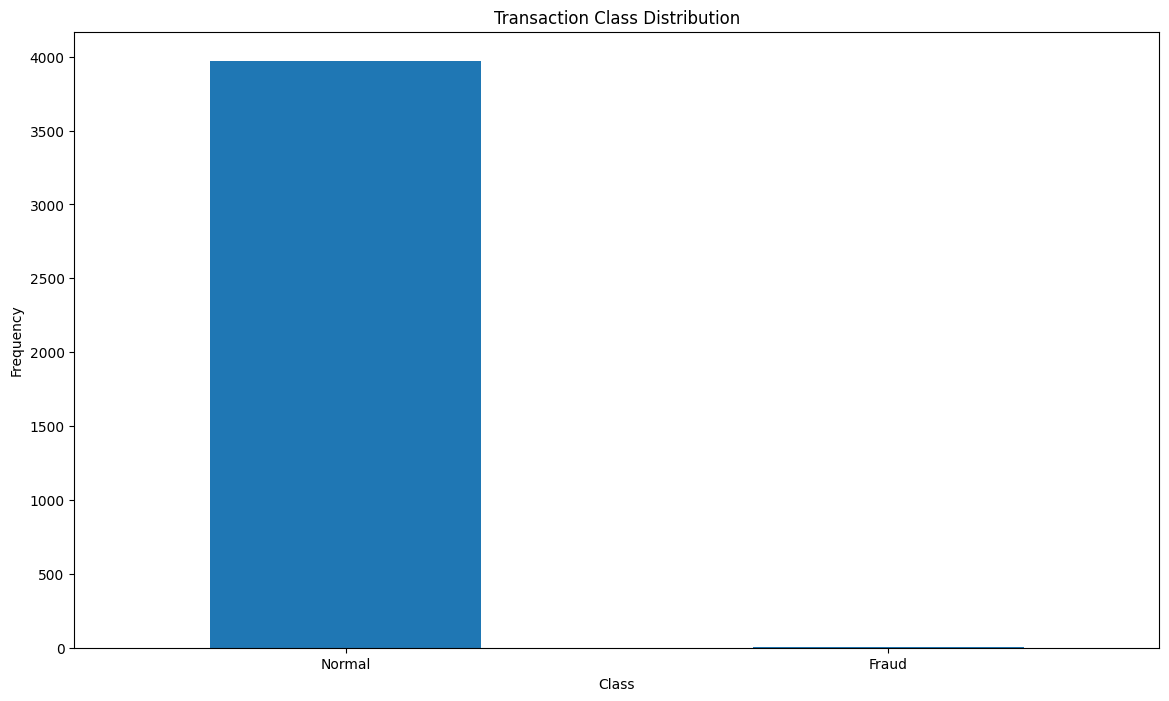

In [ ]:
count_classes = pd.value_counts(data['Class'], sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.title("Transaction Class Distribution")

plt.xticks(range(2), LABELS)

plt.xlabel("Class")

plt.ylabel("Frequency")

In [ ]:
## Get the Fraud and the normal dataset

fraud = data[data['Class']==1]

normal = data[data['Class']==0]

In [ ]:
print(fraud.shape,normal.shape)

(2, 31) (1983, 31)


In [ ]:
fraud.Amount.describe()

,Amount
count,2.000000
mean,264.500000
std,374.059487
min,0.000000
25%,132.250000
50%,264.500000
75%,396.750000
max,529.000000


In [ ]:
normal.Amount.describe()

,Amount
count,3970.000000
mean,64.899597
std,213.612570
min,0.000000
25%,2.270000
50%,12.990000
75%,54.990000
max,7712.430000


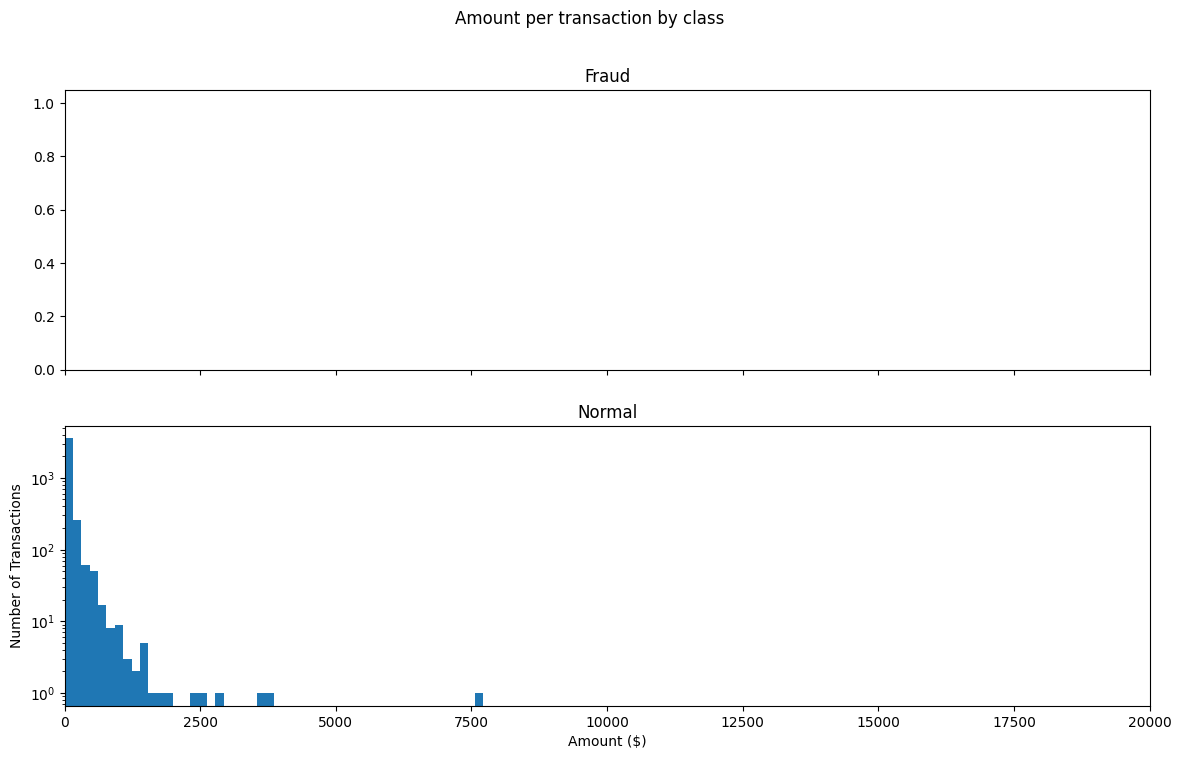

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 50
ax1.hist(fraud.Amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

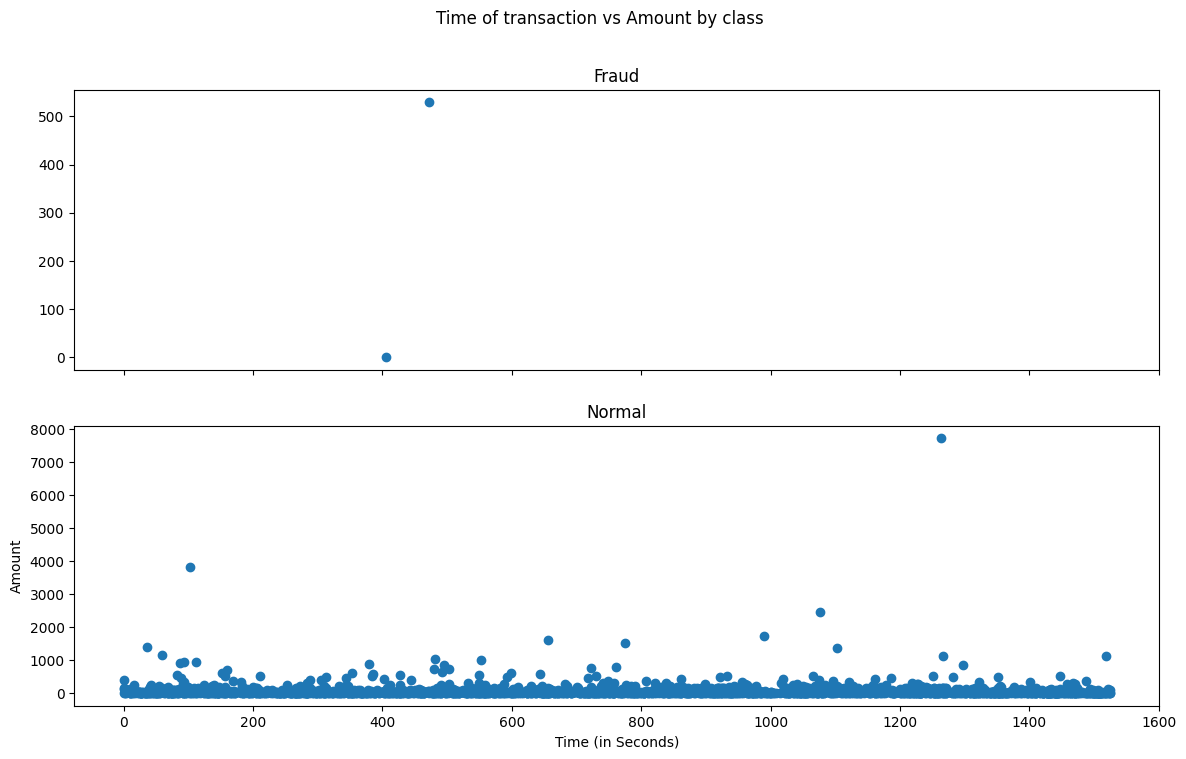

In [ ]:
# We Will check Do fraudulent transactions occur more often during certain time frame ? Let us find out with a visual representation.

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')
ax1.scatter(fraud.Time, fraud.Amount)
ax1.set_title('Fraud')
ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [ ]:
## Take some sample of the data

data1= data.sample(frac = 0.1,random_state=1)

data1.shape

(397, 31)

In [ ]:
data.shape

(3973, 31)

In [ ]:
#Determine the number of fraud and valid transactions in the dataset

Fraud = data1[data1['Class']==1]

Valid = data1[data1['Class']==0]

outlier_fraction = len(Fraud)/float(len(Valid))

In [ ]:
print(outlier_fraction)

print("Fraud Cases : {}".format(len(Fraud)))

print("Valid Cases : {}".format(len(Valid)))

0.0
Fraud Cases : 0
Valid Cases : 397


### Correlation

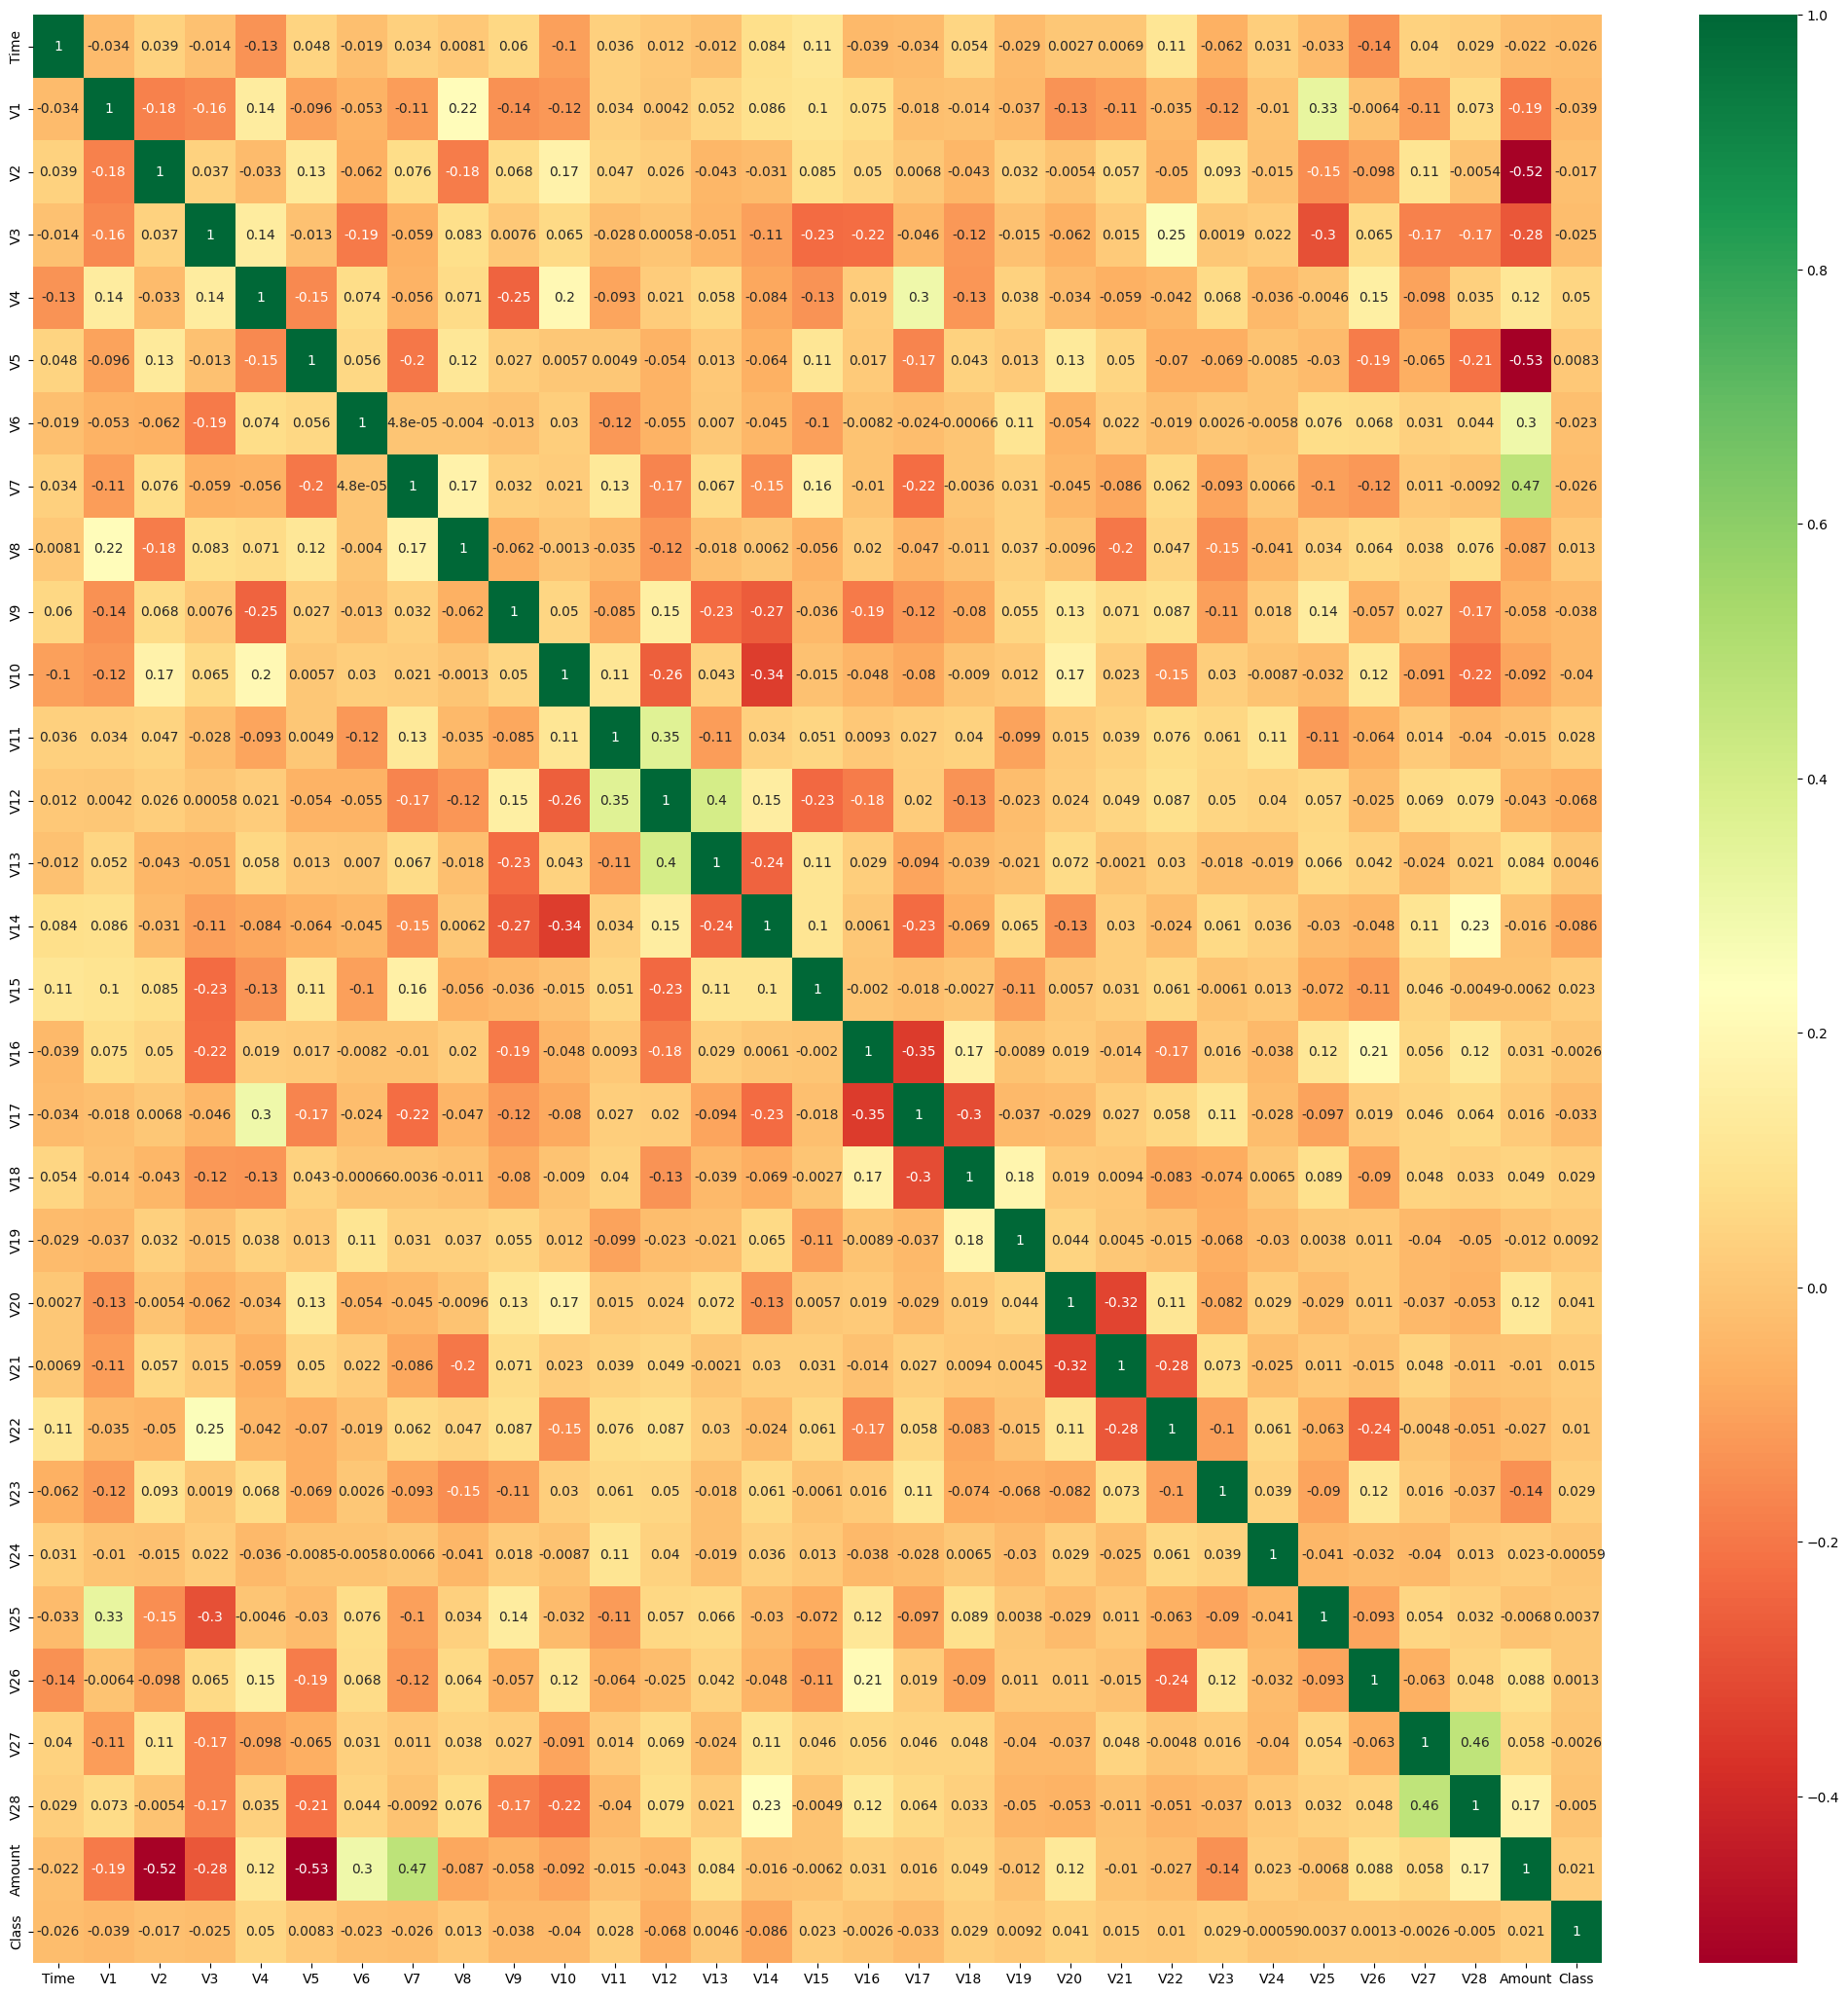

In [ ]:
## Correlation
import seaborn as sns
#get correlations of each features in dataset
corrmat = data1.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(26,26))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [ ]:
#Create independent and Dependent Features
columns = data1.columns.tolist()
# Filter the columns to remove data we do not want
columns = [c for c in columns if c not in ["Class"]]
# Store the variable we are predicting
target = "Class"
# Define a random state
state = np.random.RandomState(42)
X = data1[columns]
Y = data1[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(397, 30)
(397,)


## Model & Analysis

# Isolation Forest

Isolation Forest is an unsupervised machine-learning algorithm used for outlier detection. It leverages the concept of isolating anomalies to detect outliers in a dataset. It builds an ensemble of isolation trees, which are binary trees that randomly partition the data points. Anomalies are expected to have shorter average path lengths in the trees, making them easier to isolate. By assigning anomaly scores based on the average path lengths, the algorithm identifies outliers as data points with low scores. Isolation Forest is particularly effective in high-dimensional datasets and does not rely on assumptions about the data distribution.

<img src="https://miro.medium.com/v2/resize:fit:1174/1*-TANPVnrnxPo-p2cnZpPHQ.png" height=80% width=80% style="text-align:center;">

# Local Outlier Factor

LOF (Local Outlier Factor) is an unsupervised anomaly detection algorithm that assesses the local density deviation of a data point compared to its neighbors. It quantifies the degree of abnormality of a data point based on its relative density.

<img src="https://www.googleapis.com/download/storage/v1/b/kaggle-forum-message-attachments/o/inbox%2F1341832%2F27b93ecfd56afa80040f9b1ebecccbed%2F1_217TN2_-cgZ1d7hZUWhYUA.png?generation=1600286513104059&alt=media" height=45% width=45% style="text-align:center;">

The LOF algorithm works by calculating a local reachability density for each data point, which represents how isolated or tightly grouped the point is compared to its neighbors. Anomaly scores are assigned based on the degree to which a point's density deviates from the density of its neighbors. Points with significantly lower density compared to their neighbors are considered outliers with higher LOF scores.

LOF is effective in identifying anomalies in datasets with varying densities or clusters of different sizes. It can handle data with complex structures and does not rely on strict assumptions about the data distribution. LOF provides a local perspective on anomalies, allowing for more fine-grained anomaly detection in the dataset.

# One Class Support Vector Machine

<img src="https://www.researchgate.net/publication/345644388/figure/fig1/AS:1024147857620994@1621187285679/Overview-of-one-class-Support-Vector-Machine-SVM.png" height=60% width=60% style="text-align:center;">

SVM (Support Vector Machine) is a supervised machine learning algorithm used for classification and regression tasks. It finds an optimal hyperplane that separates data points into different classes or predicts continuous values. SVM aims to maximize the margin between classes, making it robust to outliers. It can handle linearly separable data and can also utilize kernels to handle non-linearly separable data by mapping it to a higher-dimensional feature space. SVM is effective in high-dimensional spaces, but it can be computationally expensive for large datasets due to its quadratic time complexity.


In [ ]:
##Define the outlier detection methods

classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X),
                                       contamination=outlier_fraction,random_state=state, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto',
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier_fraction),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05,
                                         max_iter=-1)
}

In [ ]:
type(classifiers)


dict

# Accuracy

# Conclusion

-	Isolation Forest detected 73 errors versus Local Outlier Factor detecting 97 errors vs. SVM detecting 8516 errors.

-	Isolation Forest has a 99.74% more accurate than LOF of 99.65% and SVM of 70.09%.

-	When comparing error precision & recall for 3 models, the Isolation Forest performed much better than the LOF as we can see that the detection of fraud cases is around 27 % versus the LOF detection rate of just 2 % and SVM of 0%.

-	So overall Isolation Forest Method performed much better in determining the fraud cases which is around 30%.

-	We can also improve on this accuracy by increasing the sample size or using deep learning algorithms however at the cost of computational expense. We can also use complex anomaly detection models to get better accuracy in determining more fraudulent cases.

